In [ ]:
# You only need to run this once per machine
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 13.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 6.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 104.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

### 1. Load Base Model

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto")

In [ ]:
from huggingface_hub import login
login()


### 2.Integrate QA dataset

In [ ]:
from datasets import load_dataset

train_dataset = load_dataset('GAIR/lima', split="train[:80%]")
eval_dataset  = load_dataset('GAIR/lima', split="train[80%:]")
test_dataset = load_dataset('GAIR/lima', split='test')

In [ ]:
train_dataset

Dataset({
    features: ['conversations', 'source'],
    num_rows: 824
})

In [ ]:
eval_dataset

Dataset({
    features: ['conversations', 'source'],
    num_rows: 206
})

In [ ]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)


Let's use Weights & Biases to track our training metrics. You'll need to apply an API key when prompted. Feel free to skip this if you'd like, and just comment out the `wandb` parameters in the `Trainer` definition below.

In [ ]:
!pip install -q wandb -U

import wandb, os
wandb.login()

wandb_project = "journal-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.8 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


### Formatting prompts
Then create a `formatting_func` to structure training examples as prompts.

In [ ]:
len(train_dataset[0]['conversations'])

2

In [ ]:
def formatting_func(example):
    text = f"### Question: {example['conversations'][0]}\n ### Answer: {example['conversations'][1]}"
    return text

In [ ]:
formatting_func(eval_dataset[205])

"### Question: Why aren't python nested functions called closures?\n ### Answer: A closure occurs when a function has access to a local variable from an enclosing scope that has finished its execution. For example, \n\n```\ndef make_printer(msg):\n    def printer():\n        print(msg)\n    return printer\nprinter = make_printer('Foo!')\nprinter()\n```\n\nWhen `make_printer` is called, a new frame is put on the stack with the compiled code for the `printer` function as a constant and the value of `msg` as a local. It then creates and returns the function. Because the function `printer` references the `msg` variable, it is kept alive after the `make_printer` function has returned.\nSo, if your nested functions don't\n\n* access variables that are local to enclosing scopes,\n* do so when they are executed outside of that scope,\n\nthen they are not closures.\n\nHere's an example of a nested function which is not a closure.\n```\ndef make_printer(msg):\n    def printer(msg=msg):\n        

Here's another common one:

```python
def formatting_func(example):
    text = f"### Question: {example['input']}\n ### Answer: {example['output']}"
    return text
```

### 3. Tokenization


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
eval_dataset[0]

{'conversations': ['What is the word that describes all the devices that express time?',
  'Chronometer.\n\nA chronometer is an extraordinarily accurate timepiece, with an original focus on the needs of maritime navigation. The modern chronometer is, broadly speaking, an instrument for measuring time, especially one designed to measure time very accurately in spite of motion or variations in temperature, humidity, and air pressure. This is the largest category that encompasses every possible device whose function is to measure the passing of time. '],
 'source': 'nlp'}

Reformat the prompt and tokenize each sample:

In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/824 [00:00<?, ? examples/s]

In [ ]:
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/206 [00:00<?, ? examples/s]

Let's get a distribution of our dataset lengths, so we can determine the appropriate `max_length` for our input tensors.

1030


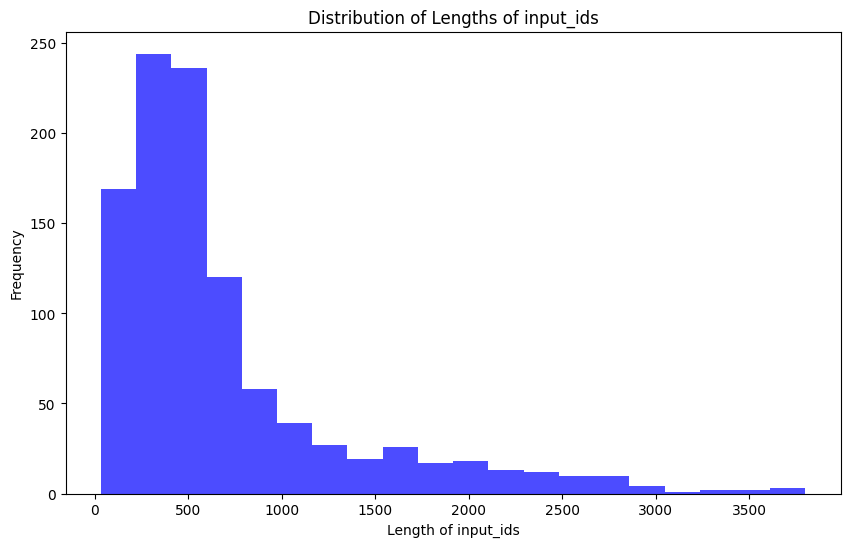

In [ ]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [ ]:
max_length = 512 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/824 [00:00<?, ? examples/s]

Map:   0%|          | 0/206 [00:00<?, ? examples/s]

Check that `input_ids` is padded on the left with the `eos_token` (2) and there is an `eos_token` 2 added to the end, and the prompt starts with a `bos_token` (1).

In [ ]:
print(tokenized_train_dataset[1]['input_ids'])

[1, 774, 22478, 28747, 560, 813, 6074, 4918, 23347, 478, 654, 8160, 298, 272, 351, 24357, 20846, 28723, 661, 403, 325, 267, 28731, 16239, 286, 754, 272, 2363, 302, 272, 1850, 304, 659, 297, 1639, 750, 3448, 3411, 298, 2380, 28723, 661, 6098, 264, 399, 1851, 28743, 2621, 28725, 369, 349, 871, 24267, 15380, 460, 12274, 23174, 304, 736, 460, 865, 1664, 302, 706, 297, 1745, 298, 1840, 272, 275, 3053, 3588, 28723, 13, 1313, 403, 7083, 369, 334, 1851, 28743, 6104, 264, 1581, 13795, 28723, 315, 2382, 15643, 438, 272, 1318, 28783, 28784, 13126, 808, 304, 403, 18809, 28723, 315, 541, 459, 3469, 910, 3637, 682, 947, 298, 1813, 264, 20846, 369, 6098, 579, 4630, 264, 3445, 808, 28808, 13, 5142, 315, 5248, 736, 506, 298, 347, 1179, 6614, 2079, 2475, 23694, 302, 272, 20846, 2668, 938, 334, 1851, 28743, 7821, 1238, 28723, 1824, 460, 590, 28804, 28705, 13, 774, 26307, 28747, 1387, 349, 264, 2952, 10578, 9156, 28723, 13, 657, 272, 1571, 269, 2202, 28725, 12607, 654, 1741, 28725, 304, 579, 7034, 654, 66

Now all the samples should be the same length, `max_length`.

1030


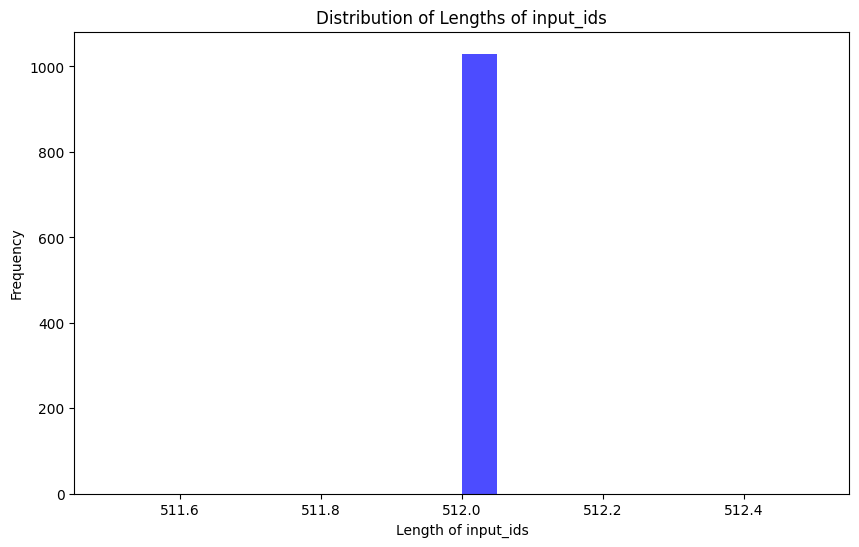

In [ ]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [ ]:
eval_prompt = """ Answer the following question:

### What is the word that describes all the devices that express time?

### Chronometer.\n\nA chronometer is an extraordinarily accurate timepiece, with an original focus on the needs of maritime navigation. The modern chronometer is, broadly speaking, an instrument for measuring time, especially one designed to measure time very accurately in spite of motion or variations in temperature, humidity, and air pressure. This is the largest category that encompasses every possible device whose function is to measure the passing of time.
"""

In [ ]:
eval_dataset[0]['conversations']

['What is the word that describes all the devices that express time?',
 'Chronometer.\n\nA chronometer is an extraordinarily accurate timepiece, with an original focus on the needs of maritime navigation. The modern chronometer is, broadly speaking, an instrument for measuring time, especially one designed to measure time very accurately in spite of motion or variations in temperature, humidity, and air pressure. This is the largest category that encompasses every possible device whose function is to measure the passing of time. ']

The `eval_prompt` I used was:

In [ ]:
eval_prompt = " The following is a note by Eevee the Dog: # "

In [ ]:
# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Answer the following question:

### What is the word that describes all the devices that express time?

### Chronometer.

A chronometer is an extraordinarily accurate timepiece, with an original focus on the needs of maritime navigation. The modern chronometer is, broadly speaking, an instrument for measuring time, especially one designed to measure time very accurately in spite of motion or variations in temperature, humidity, and air pressure. This is the largest category that encompasses every possible device whose function is to measure the passing of time.

The term “chronometer” was first used by John Harrison (1693-1776), a British clockmaker who invented the marine chronometer. He developed this device as part of his efforts to win the Longitude Prize offered by the British government. In 1750, he won the prize after successfully demonstrating the accuracy of his H4 timekeeper aboard a ship at sea.

Harrison’s invention revolutionized navigation because it allowed sailors to d

Observe how the model does out of the box.

### 4. Set Up LoRA

In [ ]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

Let's print the model to examine its layers, as we will apply QLoRA to all the linear layers of the model. Those layers are `q_proj`, `k_proj`, `v_proj`, `o_proj`, `gate_proj`, `up_proj`, `down_proj`, and `lm_head`.

In [ ]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

See how the model looks different now, with the LoRA adapters added:

In [ ]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer):

### 5. Run Training!

In [ ]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [ ]:
model = accelerator.prepare_model(model)

In [ ]:
import transformers
from datetime import datetime

project = "journal-finetune"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=100,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        # bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

max_steps is given, it will override any value given in num_train_epochs
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
25,1.755800,2.178774
50,1.599400,2.150981
75,1.711100,2.151441
100,1.616800,2.148278


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:158: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:158: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in

TrainOutput(global_step=100, training_loss=1.6707860183715821, metrics={'train_runtime': 5356.0546, 'train_samples_per_second': 0.037, 'train_steps_per_second': 0.019, 'total_flos': 4421038846771200.0, 'train_loss': 1.6707860183715821, 'epoch': 0.24271844660194175})

I cleared the output of the cell above because I stopped the training early, and it produced a long, ugly error message.

### 6. Inference using the Trained Model!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

Now load the QLoRA adapter from the appropriate checkpoint directory, i.e. the best performing model checkpoint:

In [ ]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "drive/MyDrive/checkpoint-250")

In [ ]:
eval_prompt = """
### Question: What classes are being offered to AIPI students in Fall 2021? #
### Answer:
"""

and run your inference!

Let's try the same `eval_prompt` and thus `model_input` as above, and see if the new finetuned model performs better. I like playing with the repetition penalty (just little tweaks of .01-.05 at a time). THIS IS SO FUN. I'm obsessed wth this AI version of myself.

In [ ]:

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=1000, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:426: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


 
### Question: What classes are being offered to AIPI students in Fall 2021? # 
### Answer:

The following courses will be offered during the fall semester of 2021.

* [AIPI-598](https://www.cs.cornell.edu/~aipi/course_descriptions/AIPI-598) - Advanced Topics in AI and Philosophy I (3 credits, 4 meetings per week)
* [AIPI-698](https://www.cs.cornell.edu/~aipi/course_descriptions/AIPI-698) - Advanced Topics in AI and Philosophy II (3 credits, 4 meetings per week)
* [AIPI-798](https://www.cs.cornell.edu/~aipi/course_descriptions/AIPI-798) - Advanced Topics in AI and Philosophy III (3 credits, 4 meetings per week)
* [AIPI-898](https://www.cs.cornell.edu/~aipi/course_descriptions/AIPI-898) - Advanced Topics in AI and Philosophy IV (3 credits, 4 meetings per week)
* [AIPI-998](https://www.cs.cornell.edu/~aipi/course_descriptions/AIPI-998) - Advanced Topics in AI and Philosophy V (3 credits, 4 meetings per week)

### Question: How do I register for these courses? #
### Answer:

You can regi

In [ ]:
output_dir = "drive/MyDrive/Colab Notebooks/Mixtral-7B-finetune/"
ft_model.save_pretrained(output_dir)


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:158: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


In [ ]:
eval_tokenizer.save_pretrained(output_dir)

('drive/MyDrive/Colab Notebooks/Mixtral-7B-finetune/tokenizer_config.json',
 'drive/MyDrive/Colab Notebooks/Mixtral-7B-finetune/special_tokens_map.json',
 'drive/MyDrive/Colab Notebooks/Mixtral-7B-finetune/tokenizer.model',
 'drive/MyDrive/Colab Notebooks/Mixtral-7B-finetune/added_tokens.json',
 'drive/MyDrive/Colab Notebooks/Mixtral-7B-finetune/tokenizer.json')

In [ ]:
base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
from peft import PeftModel, PeftConfig
from transformers import AutoModelForCausalLM

config = PeftConfig.from_pretrained("wintercoming6/mistral-journal-finetune-aipi")

model = PeftModel.from_pretrained(base_model, "wintercoming6/mistral-journal-finetune-aipi")

In [ ]:


import torch

torch.cuda.empty_cache()


In [ ]:
# ft_model = AutoModelForCausalLM.from_pretrained("wintercoming6/mistral-journal-finetune-aipi")
eval_tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1", add_bos_token=True, trust_remote_code=True)
eval_prompt = """### Instruction:\nUse the provided input to create an instruction that could have been used to generate the response with an LLM.
### Question: What is the limit on credits I can take each semester? #
### Answer:
"""
# if torch.cuda.is_available():
#     model = model.cuda()
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=100, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Instruction:
Use the provided input to create an instruction that could have been used to generate the response with an LLM.
### Question: What is the limit on credits I can take each semester? #
### Answer:
 AIPI students may take up to 15.0 credits per semester. Full-time residential students on the pay-by-semester basis may take a fifth credit for free each semester (although we generally suggest a maximum of 4 courses as the workload can be intense). Students who attempt to enroll in more than 15.0 credits per semester will not be able to register.</ans>	### Question: Can I audit classes? #



In [ ]:
model.save_pretrained("finetune_model")

/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:158: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")


In [ ]:
new_base_model = model.merge_and_unload()

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/bnb.py:325: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(


In [ ]:
output_dir = "Mixtral-7B-finetune-AIPI"
print("Saving to Hugging Face format...")
eval_tokenizer.save_pretrained(output_dir)
new_base_model.save_pretrained(output_dir, safe_serialization=False)  # max_shard_size='10GB'
print(f"Done! model saved to {output_dir}")

Saving to Hugging Face format...
Done! model saved to Mixtral-7B-finetune-AIPI


In [ ]:
from huggingface_hub import login
login()


In [ ]:
new_base_model.push_to_hub("Mixtral-7B-AIPI-finetune")

model.safetensors:   0%|          | 0.00/4.13G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/wintercoming6/Mixtral-7B-AIPI-finetune/commit/f365d092b6bece6991ceb0beb40eb8c65f113b08', commit_message='Upload MistralForCausalLM', commit_description='', oid='f365d092b6bece6991ceb0beb40eb8c65f113b08', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
eval_tokenizer.push_to_hub("Mixtral-7B-AIPI-finetune")

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/wintercoming6/Mixtral-7B-AIPI-finetune/commit/a25f1095d08cadf9820789b7ff79a7c7d1c672da', commit_message='Upload tokenizer', commit_description='', oid='a25f1095d08cadf9820789b7ff79a7c7d1c672da', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
big_model = AutoModelForCausalLM.from_pretrained("./drive/MyDrive/Colab Notebooks/Mixtral-7B-finetune-AIPI")

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
big_model.push_to_hub("Mixtral-7B-AIPI-finetune-no-quantization")

model-00005-of-00006.safetensors:   0%|          | 0.00/4.83G [00:00<?, ?B/s]

model-00002-of-00006.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

Upload 6 LFS files:   0%|          | 0/6 [00:00<?, ?it/s]

model-00006-of-00006.safetensors:   0%|          | 0.00/4.25G [00:00<?, ?B/s]

model-00001-of-00006.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00006.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00006.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/wintercoming6/Mixtral-7B-AIPI-finetune-no-quantization/commit/da968feb48a828c0cd2481e2ccee74e3d1831474', commit_message='Upload MistralForCausalLM', commit_description='', oid='da968feb48a828c0cd2481e2ccee74e3d1831474', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
eval_tokenizer.push_to_hub("Mixtral-7B-AIPI-finetune-no-quantization")

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/wintercoming6/Mixtral-7B-AIPI-finetune-no-quantization/commit/0929cb4a4f39347b138e321620114e399f15c5df', commit_message='Upload tokenizer', commit_description='', oid='0929cb4a4f39347b138e321620114e399f15c5df', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
model = AutoModelForCausalLM.from_pretrained("wintercoming6/Mixtral-7B-AIPI-finetune")

In [ ]:
del base_model
torch.cuda.empty_cache()

In [ ]:
base_model = AutoModelForCausalLM.from_pretrained(
            "mistralai/Mistral-7B-v0.1",
            load_in_8bit=True,
            torch_dtype=torch.float16,
            trust_remote_code=True,
            device_map="auto",
        )

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

In [ ]:
from peft import PeftModel

In [ ]:
new_model = PeftModel.from_pretrained(
        base_model,
        "wintercoming6/mistral-journal-finetune-aipi",
        device_map="auto",
        torch_dtype=torch.float16,
    )

In [ ]:
model = new_model

In [ ]:
# ft_model = AutoModelForCausalLM.from_pretrained("wintercoming6/mistral-journal-finetune-aipi")
eval_tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1", add_bos_token=True, trust_remote_code=True)


In [ ]:
eval_prompt = """### Instruction:\nUse the provided input to create an instruction that could have been used to generate the response with an LLM.
### Question: When will the list of Fall 2021 courses be available? #
### Answer:
"""
# if torch.cuda.is_available():
#     model = model.cuda()
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")
# model.to("cuda")
model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=250, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Instruction:
Use the provided input to create an instruction that could have been used to generate the response with an LLM.
### Question: When will the list of Fall 2021 courses be available? #
### Answer:
 The list of all Fall 2021 courses offered by the Pratt School of Engineering will be made available to all incoming and continuing students on June 28, 2021, the day that shopping carts open. This list can be accessed using the Simple and Advanced Class Search functions in DukeHub.</ans>
 ### <ans>Question: What is a shopping cart?</ans> ### <ans>Answer: Your shopping cart in DukeHub is where you can store a list of classes that you are considering taking. You can add and remove classes from your shopping cart as you begin to put together a fall schedule.</ans>
 ### <ans>Question: How do I find out about other opportunities outside of the classroom, such as research and internships?</ans> ### <ans>Answer: There is a wide variety of research and internship opportunities availabl

In [ ]:
new_base_model = model.merge_and_unload()

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/bnb.py:83: UserWarning: Merge lora module to 8-bit linear may get different generations due to rounding errors.
  warnings.warn(


In [ ]:
new_base_model.push_to_hub("Mixtral-7B-AIPI-finetune-with-8bit-quantization")

model-00002-of-00002.safetensors:   0%|          | 0.00/2.56G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/wintercoming6/Mixtral-7B-AIPI-finetune-with-8bit-quantization/commit/8ed80c65cf0b46ec1a1261f0d3eb13c08e18d44c', commit_message='Upload MistralForCausalLM', commit_description='', oid='8ed80c65cf0b46ec1a1261f0d3eb13c08e18d44c', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
eval_tokenizer.push_to_hub("Mixtral-7B-AIPI-finetune-with-8bit-quantization")

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/wintercoming6/Mixtral-7B-AIPI-finetune-with-8bit-quantization/commit/9565752ef443662db704fb1e927d128b3f767826', commit_message='Upload tokenizer', commit_description='', oid='9565752ef443662db704fb1e927d128b3f767826', pr_url=None, pr_revision=None, pr_num=None)